Problem Statement: Can we accurately predict insurance costs 

Given:Past Insurance Claim Data

Columns

age: age of primary beneficiary

sex: insurance contractor gender, female, male

bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

children: Number of children covered by health insurance / Number of dependents

smoker: Smoking

region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

charges: Individual medical costs billed by health insurance


Outcome: Initial Exploratory Analysis and Modelling to arrive at model selections based on experiments with pipelines and gridsearch; Also using comet.ml for running experiments and hyperparameter tuning.

The original Notebook at : https://www.kaggle.com/pyaligar/notebook0325f93125

In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [49]:
data=pd.read_csv('/kaggle/input/insurance/insurance.csv');

In [50]:
!pip install comet_ml

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [51]:
# import comet_ml at the top of your file
from comet_ml import Experiment

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
comet_api_key = user_secrets.get_secret("comet-label")

In [52]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [53]:
data.shape

(1338, 7)

In [54]:
! pip freeze | grep seaborn

seaborn==0.11.1


#Exploratory Analysis

In [55]:
pip install -U seaborn


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [56]:
import seaborn as sns
sns.__version__

'0.11.1'

In [57]:
import matplotlib.pyplot as plt

In [58]:
from sklearn.model_selection import train_test_split

EDA¶

In [59]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Insights : No missing values

In [60]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Insights
#Suggests some skewness in charges: Mode 9382.   Right skewed (median < Mean)
#Age seems to be normally distributed
#All others  - BMI, Children also normally distributed

Catagorical ones

In [61]:
data.sex.value_counts() 

male      676
female    662
Name: sex, dtype: int64

In [62]:
data.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

In [63]:
data.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

Insights
#sex,region balanced
#Smoker is imbalanced

See relationships with target variable

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


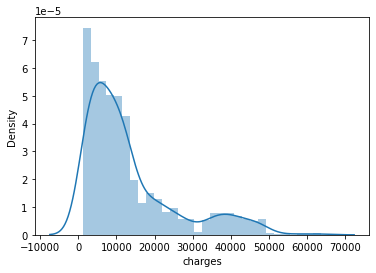

In [64]:
sns.distplot(data.charges)

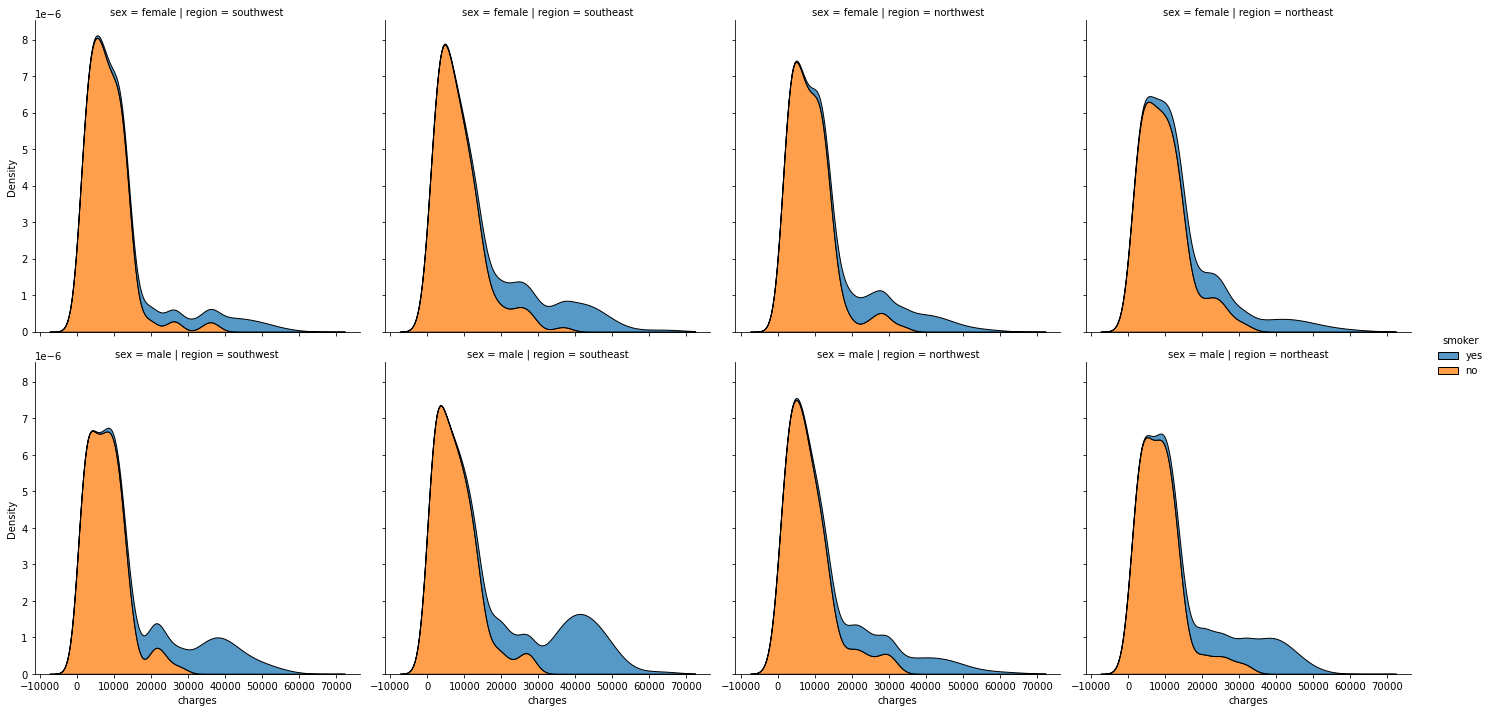

In [65]:
sns.displot(data=data, 
            x='charges',
            row='sex',
            col='region',
            hue='smoker',
            fill=True,
            multiple='stack',
            kind='kde')

learn more plots here 
https://seaborn.pydata.org/tutorial/distributions.html

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of charges for non-smokers')

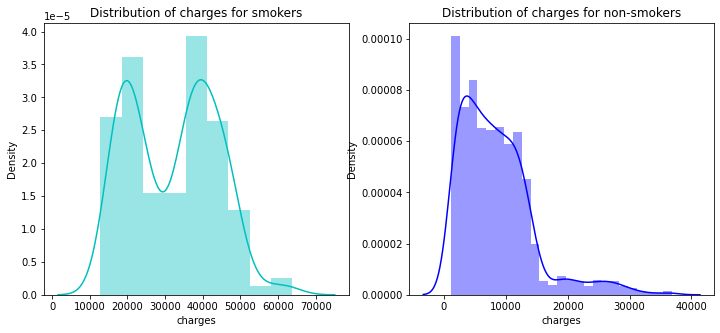

In [66]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == "yes")]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == "no")]["charges"],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')




In [67]:
#Voilin plots

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64
sex
female            NaN
male      1387.172334
Name: charges, dtype: float64


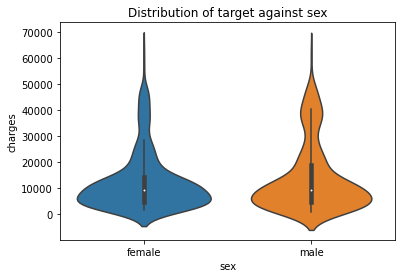

In [68]:
var = 'sex'
mean_data = data.groupby(var).charges.mean()
print(mean_data)
print(mean_data.diff())
sns.violinplot(data=data, x=var, y='charges')
plt.title('Distribution of target against '+var)
plt.show()

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64
smoker
no              NaN
yes    23615.963534
Name: charges, dtype: float64


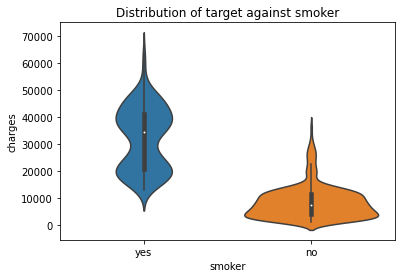

In [69]:
#smoker
var = 'smoker'
mean_data = data.groupby(var).charges.mean()
print(mean_data)
print(mean_data.diff())
sns.violinplot(data=data, x=var, y='charges')
plt.title('Distribution of target against '+var)
plt.show()

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64


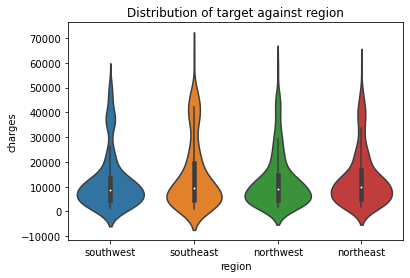

In [70]:
var = 'region'
mean_data = data.groupby(var).charges.mean()
print(mean_data)
#print(mean_data.diff())
sns.violinplot(data=data, x=var, y='charges')
plt.title('Distribution of target against '+var)
plt.show()

Insights
* sex, region do not seem to have much impact on the target
* smoker has high  impact

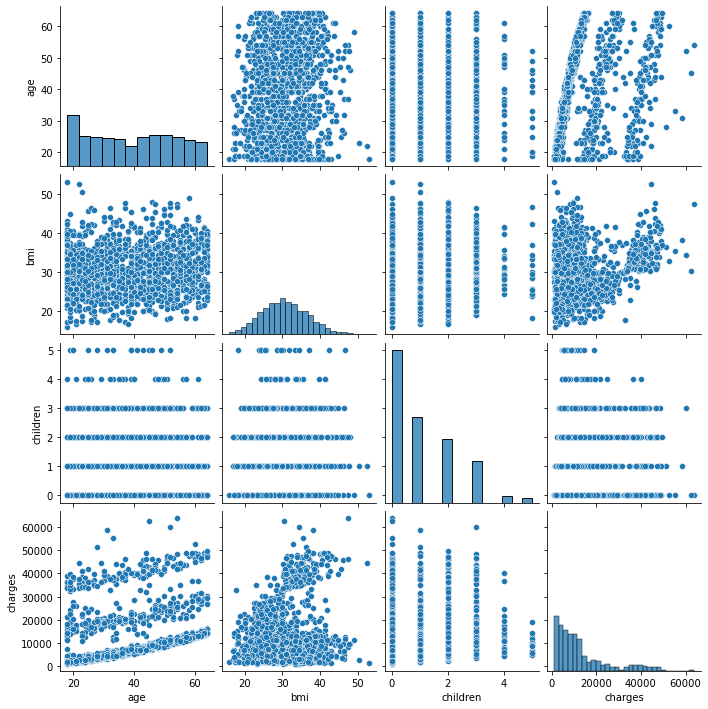

In [71]:
sns.pairplot(data)

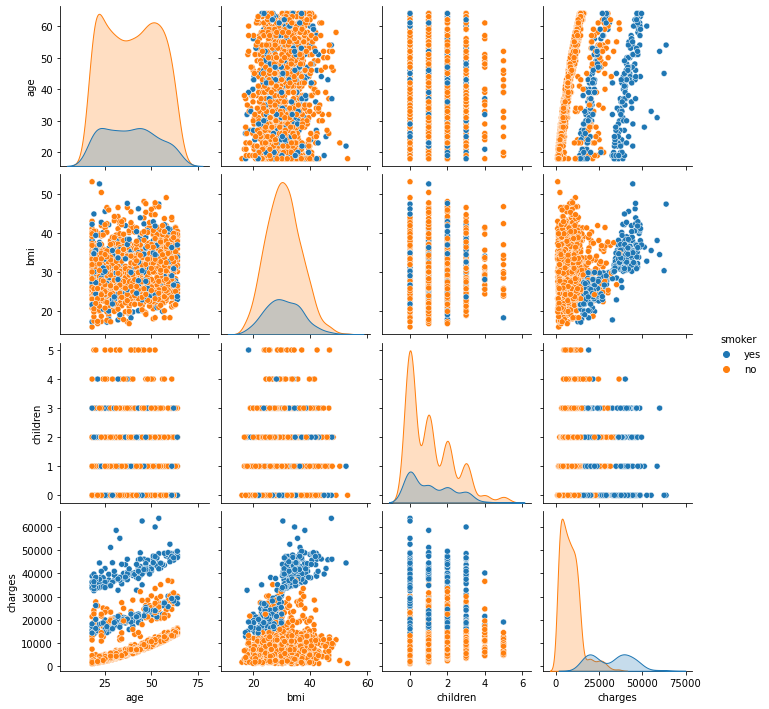

In [72]:
sns.pairplot(data,hue='smoker')

Insights
* smokers have more charges
* higher charges with age
* bmi has influence on charges
* higher if no children?

Hypothesis¶

We have already visualized the relationship of the variables to the charges. Now we will further investigate by looking at the relationships using multiple linear regression. The aim of this section is to quantify the relationship and not to create the prediction model. 

Based on the visualization, we can make a couple of hypothesis about the relationship.


* There is no influence of gender or region on onn charges.

* The charge for smokers are very much higher than for the non-smokers.

* The charge gets higher with age.

* The charge gets higher as the individual reaches 30BMI or above.

* Lastly, the charge is higher for those who have fewer number of children.

Let us first create a training and testing data set to proceed.

# Preprocessing¶

In [73]:
#Form the hypothesis - form OLS
#before that convert catagoricals

data = pd.get_dummies(data, prefix=['sex','smoker','region'], drop_first=True)
data.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [74]:
# split train-test
X = data.drop(columns='charges') 
y = data.loc[:,'charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Quantify effects¶

In [75]:
import statsmodels.api as sm
from scipy import stats

In [76]:
#Fit OLD model - needs the constant to be passed

X_train_const = sm.add_constant(X_train)
linearModel = sm.OLS(y_train, X_train_const)
linear = linearModel.fit()
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     314.8
Date:                Sun, 17 Jan 2021   Prob (F-statistic):          3.47e-258
Time:                        09:12:38   Log-Likelihood:                -9495.3
No. Observations:                 936   AIC:                         1.901e+04
Df Residuals:                     927   BIC:                         1.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.184e+04   1205.932  

# Conclusions:
    
There is no real difference in charges between gender (p-value 0.907) or regions (p-value 0.342, 0.093, 0.173).
* since all the p-values > 0.05 that means these variables do not have statistical significane on the target variable

The charge for smokers are very much higher than the non-smokers (p-value 0.000)
* since p-value < 0.05 this variable is statistically significant

The charge gets higher as the individual gets older (p-value 0.000).
* since p-value < 0.05 this variable is statistically significant

The charge gets higher as the individual reaches over 30BMI (p-value 0.000).
* since p-value < 0.05 this variable is statistically significant

Lastly, the charge is higher for those who have fewer number of children (p-value 0.005).
* since p-value < 0.05 this variable is statistically significant, meaning there is evidence that charges are different for people with fewer than people with more children

# Build model¶

In [77]:
#Build pipeline and use GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

see pipeline and gridsearchcv examples [here](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py) and [here](https://www.kaggle.com/carlosdg/xgboost-with-scikit-learn-pipeline-gridsearchcv)
    

In [78]:
pipeline = Pipeline([
    ('scaling', 'passthrough'),
    ('model','passthrough')
])

param_grid = {
    'scaling': [StandardScaler(), MinMaxScaler()],
    'model' : [LinearRegression(), Ridge(), Lasso(), ElasticNet()]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

In [80]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaling', 'passthrough'),
                                       ('model', 'passthrough')]),
             n_jobs=-1,
             param_grid={'model': [LinearRegression(), Ridge(), Lasso(),
                                   ElasticNet()],
                         'scaling': [StandardScaler(), MinMaxScaler()]},
             scoring='r2')

In [81]:
grid.best_estimator_

Pipeline(steps=[('scaling', MinMaxScaler()), ('model', Ridge())])

In [82]:
grid.score(X_test, y_test)

0.7902982628628683

# Track experiments on comet_ml¶
learn more [here](https://www.comet.ml/docs/python-sdk/scikit/) 

In [83]:
for i in range(len(grid.cv_results_['params'])):
    exp = Experiment(workspace="yaligarp",
        project_name="saturday-codealong-medical-insurance-costs-predict",
        api_key=comet_api_key)
    for k,v in grid.cv_results_.items():
        if k == "params":
            exp.log_parameters(v[i])
        else:
            exp.log_metric(k,v[i])
    exp.end()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yaligarp/saturday-codealong-medical-insurance-costs-predict/75f385abe51344ee9c60f385cefab670

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/yaligarp/saturday-codealong-medical-insurance-costs-predict/75f385abe51344ee9c60f385cefab670
COMET INFO:   Metrics:
COMET INFO:     mean_fit_time     : 0.04587469100952148
COMET INFO:     mean_score_time   : 0.004943180084228516
COMET INFO:     mean_test_score   : 0.7212481438683181
COMET INFO:     param_model       : LinearRegression()
COMET INFO:     param_scaling     : StandardScaler()
COMET INFO:     rank_test_score   : 5
COMET INFO:     split0_test_score : 0.7631162938389975
COMET INFO:     split1_test_score : 0.6960918755682493
COMET INFO:     split2_test_score : 0.7313281698851035
COME

COMET INFO:     std_score_time    : 0.000479442000000795
COMET INFO:     std_test_score    : 0.024820466215686968
COMET INFO:   Parameters:
COMET INFO:     model   : Lasso()
COMET INFO:     scaling : StandardScaler()
COMET INFO:   Uploads:
COMET INFO:     code                : 1 (12 KB)
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO: ---------------------------
COMET INFO: Still uploading
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yaligarp/saturday-codealong-medical-insurance-costs-predict/2a099f9e13cb47f3a4a2fb9483082b84

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/yaligarp/saturday-codealong-medical-insuran

1. see experiemnt [here](https://www.comet.ml/yaligarp/saturday-codealong-medical-insurance-costs-predict/e961de32e76047cf8e487f252c24ae85?experiment-tab=chart&showOutliers=true&smoothing=0&transformY=smoothing&xAxis=wall) 